# Figure 3: Simulated Algorithmic Ranking

In [1]:
source('../scripts/load_libraries.R')
source('../scripts/load_constants.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘lemon’


The following objects are masked from ‘package:ggplot2’:

    CoordCartesian, element_render




In [2]:
source('../scripts/load_data.R')

Rows: 17264341 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): comment_id, user_id, author_id, anonymous, first_view

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1281001 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, score, time_stamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 223737 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, num, time_stamp

ℹ Use `spec()` t

In [3]:
by_author <- df %>% 
  filter(ds < '2012-09-05') %>%
  group_by(author_id, identified) %>%
  summarise(up = sum(up), dn = sum(dn), exp = n())

`summarise()` has grouped output by 'author_id'. You can override using the `.groups` argument.


In [4]:
by_author_sampled <- df %>% 
  filter(ds < '2012-09-05', identified == 1) %>%
  sample_frac(1/19) %>%
  group_by(author_id, identified) %>%
  summarise(up = sum(up), dn = sum(dn), exp = n())

`summarise()` has grouped output by 'author_id'. You can override using the `.groups` argument.


In [5]:
iden_ratings <- by_author_sampled %>% 
  filter(identified == 1) %>%
  add_ebb_estimate(up, exp) %>%
  select(author_id, up, dn, exp, up.score = .fitted) %>%
  add_ebb_estimate(dn, exp) %>%
  select(author_id, up, dn, exp, up.score, dn.score = .fitted)

anon_ratings <- by_author %>% 
  filter(identified == 0) %>%
  add_ebb_estimate(up, exp) %>%
  select(author_id, up, dn, exp, up.score = .fitted) %>%
  add_ebb_estimate(dn, exp) %>%
  select(author_id, up, dn, exp, up.score, dn.score = .fitted)

Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


In [6]:
one_month <- df %>% 
  filter(ds >= '2012-09-05', ds < '2012-10-05')

In [7]:
for_plot <- one_month %>%
  filter(identified == 0) %>%
  group_by(ds, comment_id) %>%
  summarise(author_id = first(author_id),
            up = sum(up), 
            dn = sum(dn)) %>%
  ungroup() %>%
  left_join(iden_ratings %>% select(author_id, iden.up = up.score, iden.dn = dn.score)) %>%
  left_join(anon_ratings %>% select(author_id, anon.up = up.score, anon.dn = dn.score)) %>%
  mutate(iden.up = coalesce(iden.up, 0),
         iden.dn = coalesce(iden.dn, 1),
         anon.up = coalesce(anon.up, 0),
         anon.dn = coalesce(anon.dn, 1),
         key = 1) %>%
  inner_join(data_frame(key = 1, alpha = seq(0, 1, by = .01))) %>%
  mutate(iden.score = iden.up * alpha - iden.dn * (1-alpha),
         anon.score = anon.up * alpha - anon.dn * (1-alpha)) %>%
  select(ds, comment_id, up, dn, alpha, iden.score, anon.score) %>%
  gather(ranker, score, iden.score, anon.score) %>%
  group_by(ds, ranker, alpha) %>%
  mutate(day.rk = min_rank(-score),
         day.cnt = max(day.rk))

`summarise()` has grouped output by 'ds'. You can override using the `.groups` argument.
Joining, by = "author_id"
Joining, by = "author_id"
Joining, by = "key"


Joining, by = "key"
`summarise()` has grouped output by 'cutoff', 'ranker'. You can override using the `.groups` argument.


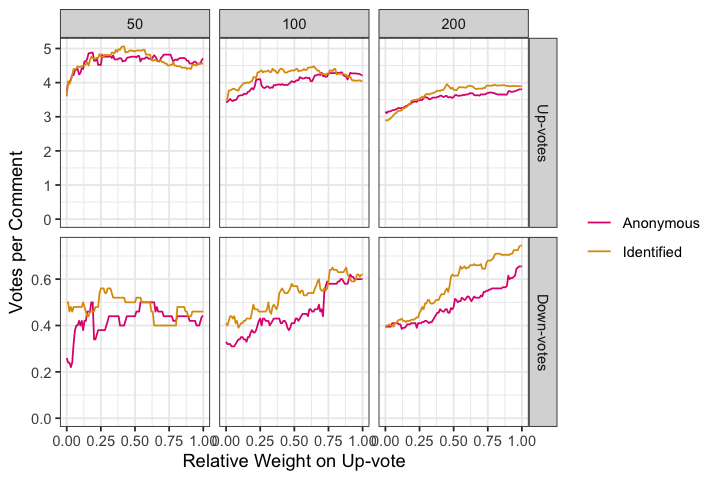

In [8]:
options(repr.plot.height=4, repr.plot.width = 6)
cutoffs <- data_frame(key = 1, cutoff = c(50, 100, 200))
p <- for_plot %>%
  mutate(key = 1) %>%
  inner_join(cutoffs) %>%
  filter(day.rk <= cutoff) %>%
  group_by(cutoff, ranker, alpha) %>%
  summarise(`Up-votes` = sum(up) / first(cutoff), `Down-votes` = sum(dn) / first(cutoff)) %>%
  gather(metric, value, -alpha, -ranker, -cutoff) %>%
  #filter(ranker != 'rand.score') %>%
  mutate(metric = factor(metric, levels = c('Up-votes', 'Down-votes'))) %>%
  #mutate(ranker = factor(ranker, levels = c('anon.score', 'iden.score'))) +
  mutate(Scoring = if_else(ranker == 'anon.score', 'Anonymous', 'Identified')) %>%
  ggplot(aes(x=alpha, y = value, color = Scoring)) + 
  #geom_smooth(se=FALSE) +
  geom_line() +
  facet_grid(metric ~ cutoff, scale='free_y') +
  xlab('Relative Weight on Up-vote') +
  ylab('Votes per Comment') +
  ylim(0, NA) +
  theme_bw() +
  theme(legend.background = element_blank(),
        legend.title = element_blank()) +
  scale_color_manual(values = c(rgb(223/255,22/255,126/255), rgb(221/255,155/255,8/255))) 
  
p

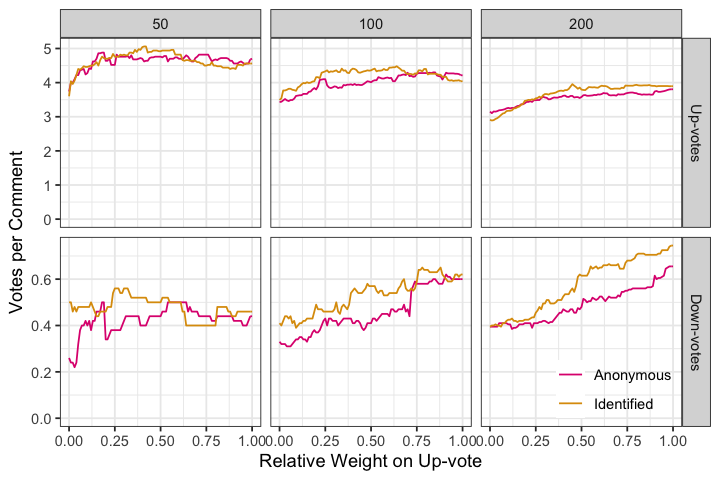

In [9]:
p2 <- lemon::reposition_legend(p, 'bottom right', panel = 'panel-2-3')
  #theme(legend.position = c(0.06, 0.75))

In [10]:
ggsave('../figures/fig-3.pdf', p2, width = 5.5, height = 3)